In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_pool(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = MaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = MaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = MaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = MaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [11]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
convBlocks = 4

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

block = embedding_dropout
for currentBlock in range(convBlocks):
  filters = 128 * (2 + currentBlock)
  block = one_by_three_cnn(filters, block)
  if(currentBlock < convBlocks-1):
    block = yoon_kim_pool(filters, block)
  
features = yoon_kim_feature_extractor(512, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 17:23 - loss: 0.1855 - acc: 0.9294

102112/102124 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9659

102124/102124 [==============================] - 1361s 13ms/step - loss: 0.0925 - acc: 0.9659 - val_loss: 0.0496 - val_acc: 0.9815
Epoch 2/32
 10080/102124 [=>............................] - ETA: 18:54 - loss: 0.0623 - acc: 0.9772

102112/102124 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9778

102124/102124 [==============================] - 1346s 13ms/step - loss: 0.0608 - acc: 0.9778 - val_loss: 0.0516 - val_acc: 0.9815
roc-auc: 0.9721 - roc-auc_val: 0.9707                                                                                                    
Epoch 3/32
  8640/102124 [=>............................] - ETA: 19:11 - loss: 0.0586 - acc: 0.9784

102112/102124 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9791

102124/102124 [==============================] - 1347s 13ms/step - loss: 0.0577 - acc: 0.9791 - val_loss: 0.0551 - val_acc: 0.9800

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004061262006871402.
Epoch 4/32
  7968/102124 [=>............................] - ETA: 19:20 - loss: 0.0576 - acc: 0.9786

102112/102124 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9798

102124/102124 [==============================] - 1346s 13ms/step - loss: 0.0561 - acc: 0.9798 - val_loss: 0.0552 - val_acc: 0.9797
roc-auc: 0.9762 - roc-auc_val: 0.973                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 18:59 - loss: 0.0535 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9804

102124/102124 [==============================] - 1331s 13ms/step - loss: 0.0538 - acc: 0.9804 - val_loss: 0.0487 - val_acc: 0.9815
Epoch 6/32
 10080/102124 [=>............................] - ETA: 19:00 - loss: 0.0550 - acc: 0.9799

102112/102124 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9808

102124/102124 [==============================] - 1346s 13ms/step - loss: 0.0521 - acc: 0.9808 - val_loss: 0.0478 - val_acc: 0.9821
roc-auc: 0.9785 - roc-auc_val: 0.976                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 19:12 - loss: 0.0522 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9812

102124/102124 [==============================] - 1345s 13ms/step - loss: 0.0507 - acc: 0.9812 - val_loss: 0.0481 - val_acc: 0.9820
Epoch 8/32
 10080/102124 [=>............................] - ETA: 18:51 - loss: 0.0510 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9815

102124/102124 [==============================] - 1345s 13ms/step - loss: 0.0499 - acc: 0.9815 - val_loss: 0.0501 - val_acc: 0.9809
roc-auc: 0.9808 - roc-auc_val: 0.9775                                                                                                    
Epoch 9/32
  8640/102124 [=>............................] - ETA: 19:12 - loss: 0.0464 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9817

102124/102124 [==============================] - 1342s 13ms/step - loss: 0.0492 - acc: 0.9817 - val_loss: 0.0491 - val_acc: 0.9811
Epoch 10/32
 10048/102124 [=>............................] - ETA: 18:35 - loss: 0.0499 - acc: 0.9805

102112/102124 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9820

102124/102124 [==============================] - 1331s 13ms/step - loss: 0.0480 - acc: 0.9820 - val_loss: 0.0493 - val_acc: 0.9810
roc-auc: 0.9822 - roc-auc_val: 0.9784                                                                                                    
Epoch 11/32
  8608/102124 [=>............................] - ETA: 19:13 - loss: 0.0471 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9822

102124/102124 [==============================] - 1340s 13ms/step - loss: 0.0470 - acc: 0.9822 - val_loss: 0.0473 - val_acc: 0.9818
Epoch 12/32
 10048/102124 [=>............................] - ETA: 18:51 - loss: 0.0451 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9822

102124/102124 [==============================] - 1342s 13ms/step - loss: 0.0464 - acc: 0.9822 - val_loss: 0.0459 - val_acc: 0.9826
roc-auc: 0.9841 - roc-auc_val: 0.9792                                                                                                    
Epoch 13/32
  8608/102124 [=>............................] - ETA: 19:08 - loss: 0.0455 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9826

102124/102124 [==============================] - 1341s 13ms/step - loss: 0.0462 - acc: 0.9826 - val_loss: 0.0472 - val_acc: 0.9819
Epoch 14/32
 10048/102124 [=>............................] - ETA: 18:50 - loss: 0.0470 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9827

102124/102124 [==============================] - 1332s 13ms/step - loss: 0.0452 - acc: 0.9827 - val_loss: 0.0485 - val_acc: 0.9813

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00012940811575390399.
roc-auc: 0.9854 - roc-auc_val: 0.9793                                                                                                    
Epoch 15/32
  5888/102124 [>.............................] - ETA: 19:38 - loss: 0.0453 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9830

102124/102124 [==============================] - 1343s 13ms/step - loss: 0.0444 - acc: 0.9830 - val_loss: 0.0456 - val_acc: 0.9829
Epoch 16/32
 10048/102124 [=>............................] - ETA: 18:50 - loss: 0.0419 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 1343s 13ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0477 - val_acc: 0.9820
roc-auc: 0.9866 - roc-auc_val: 0.9796                                                                                                    
Epoch 17/32
  8608/102124 [=>............................] - ETA: 19:18 - loss: 0.0426 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9832

102124/102124 [==============================] - 1344s 13ms/step - loss: 0.0432 - acc: 0.9832 - val_loss: 0.0450 - val_acc: 0.9832
Epoch 18/32
 10048/102124 [=>............................] - ETA: 18:57 - loss: 0.0413 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9835

102124/102124 [==============================] - 1341s 13ms/step - loss: 0.0428 - acc: 0.9835 - val_loss: 0.0474 - val_acc: 0.9821
roc-auc: 0.9876 - roc-auc_val: 0.9799                                                                                                    
Epoch 19/32
  8608/102124 [=>............................] - ETA: 18:57 - loss: 0.0450 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 1341s 13ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0484 - val_acc: 0.9822
Epoch 20/32
 10048/102124 [=>............................] - ETA: 18:59 - loss: 0.0430 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9835

102124/102124 [==============================] - 1344s 13ms/step - loss: 0.0422 - acc: 0.9835 - val_loss: 0.0471 - val_acc: 0.9824
roc-auc: 0.9879 - roc-auc_val: 0.9797                                                                                                    
Epoch 21/32
  8608/102124 [=>............................] - ETA: 19:12 - loss: 0.0404 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9839

102124/102124 [==============================] - 1341s 13ms/step - loss: 0.0415 - acc: 0.9838 - val_loss: 0.0455 - val_acc: 0.9831
Epoch 22/32
 10048/102124 [=>............................] - ETA: 18:51 - loss: 0.0417 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9838

102124/102124 [==============================] - 1341s 13ms/step - loss: 0.0411 - acc: 0.9838 - val_loss: 0.0463 - val_acc: 0.9827
roc-auc: 0.9888 - roc-auc_val: 0.9804                                                                                                    
Epoch 23/32
  8608/102124 [=>............................] - ETA: 19:11 - loss: 0.0399 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9839

102124/102124 [==============================] - 1334s 13ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.0466 - val_acc: 0.9829
Epoch 24/32
 10048/102124 [=>............................] - ETA: 18:33 - loss: 0.0406 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9838

102124/102124 [==============================] - 1334s 13ms/step - loss: 0.0410 - acc: 0.9838 - val_loss: 0.0453 - val_acc: 0.9831
roc-auc: 0.9894 - roc-auc_val: 0.9804                                                                                                    
Epoch 25/32
  8608/102124 [=>............................] - ETA: 19:12 - loss: 0.0412 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 1340s 13ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0452 - val_acc: 0.9833

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.123462349525653e-05.
Epoch 26/32
  7968/102124 [=>............................] - ETA: 19:18 - loss: 0.0417 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9841

102124/102124 [==============================] - 1345s 13ms/step - loss: 0.0401 - acc: 0.9841 - val_loss: 0.0461 - val_acc: 0.9830
roc-auc: 0.9899 - roc-auc_val: 0.98                                                                                                    
Epoch 27/32
  8672/102124 [=>............................] - ETA: 19:18 - loss: 0.0388 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9841

102124/102124 [==============================] - 1346s 13ms/step - loss: 0.0401 - acc: 0.9841 - val_loss: 0.0451 - val_acc: 0.9834


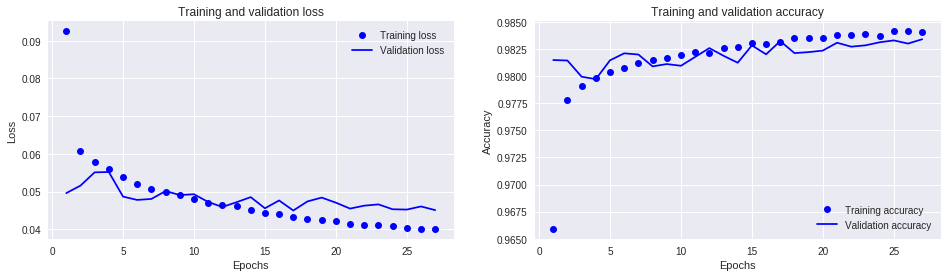

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 111s 3ms/step
([0.042823998795534245, 0.9837119302834797], 0.9840809249632372)
